#####  CNN을 이용하여 손글씨 숫자 인식하기

In [1]:
import numpy as np
import tensorflow as tf

seed=0

np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train),(X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
# 훈련 데이터 1000개 , 테스트 데이터 300개
X_train = X_train[:1000,:]
y_train = y_train[:1000]
X_test = X_test[:300,:]
y_test = y_test[:300]

In [5]:
X_train.shape, X_test.shape

((1000, 28, 28), (300, 28, 28))

In [6]:
import pandas as pd
# 2차원 데이터에 색상 차원을 추가(흑백1, 칼라3)
X_train= X_train.reshape(X_train.shape[0],28,28,1)
X_test= X_test.reshape(X_test.shape[0],28,28,1)

# 0-255 범위의 픽셀값을 0-1 사이의 범위로 변경
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

# 이진분류이므로 y를 원핫 인코딩
y_train =pd.get_dummies(y_train)
y_test =pd.get_dummies(y_test)

y_train.shape, y_test.shape


((1000, 10), (300, 10))

#####  입력층에 cnn을 추가해서 학습모델 설계

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()

# 입력층 (CNN층)
# filters : 필터의 수, 출력의 수 (출력되는 이미지의 개수)
# kernel_size : 필터의 크기 (3,3) (5,5), (7,7)
# input_shape : 입력데이터의 크기 (2차원 이상인 경우에 사용)
# padding : 컨벌루션 연산때문에 작아지는 이미지 크기를 유지할 것인 여부
# same : 항상 같은 크기로 이미지를 유지해준다.  - padding
# valid : 컬벌루션으로 줄어든 상태를 그대로 유지
model.add(Conv2D(filters = 32 ,
                     kernel_size = (3,3) , 
                     input_shape = (28,28,1),
                     padding = "valid" , 
                     activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
# 은닉층에 넣기 전에 이전 데이터들을 1차원으로 변환
model.add(Flatten())

#은닉층
model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.2))
# 출력층
model.add(Dense(units = 10, activation = "softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               692352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
________________________________________________

In [20]:
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["acc"])

In [21]:
h = model.fit(X_train, y_train, epochs=30, batch_size=100,
         validation_data=(X_test,y_test))

Train on 1000 samples, validate on 300 samples
Epoch 1/30
1000/1000 [==============================] - 1s 606us/sample - loss: 1.8257 - acc: 0.5130 - val_loss: 1.2834 - val_acc: 0.7000
Epoch 2/30
1000/1000 [==============================] - 0s 211us/sample - loss: 0.8773 - acc: 0.7620 - val_loss: 0.6718 - val_acc: 0.8233
Epoch 3/30
1000/1000 [==============================] - 0s 225us/sample - loss: 0.5252 - acc: 0.8430 - val_loss: 0.4822 - val_acc: 0.8600
Epoch 4/30
1000/1000 [==============================] - 0s 249us/sample - loss: 0.3811 - acc: 0.8850 - val_loss: 0.3733 - val_acc: 0.8833
Epoch 5/30
1000/1000 [==============================] - 0s 239us/sample - loss: 0.2973 - acc: 0.9220 - val_loss: 0.3308 - val_acc: 0.8933
Epoch 6/30
1000/1000 [==============================] - 0s 237us/sample - loss: 0.2607 - acc: 0.9190 - val_loss: 0.3068 - val_acc: 0.9100
Epoch 7/30
1000/1000 [==============================] - 0s 242us/sample - loss: 0.2059 - acc: 0.9400 - val_loss: 0.2611 - val

In [22]:
print("훈련 정확도 : ", model.evaluate(X_train,y_train))
print("테스트 정확도 : ", model.evaluate(X_test,y_test))

1000/1000 [==============================] - 0s 158us/sample - loss: 0.0035 - acc: 1.0000
훈련 정확도 :  [0.0034775346480309965, 1.0]
300/300 [==============================] - 0s 66us/sample - loss: 0.2013 - acc: 0.9333
테스트 정확도 :  [0.20134323398272197, 0.93333334]


#####  시각화

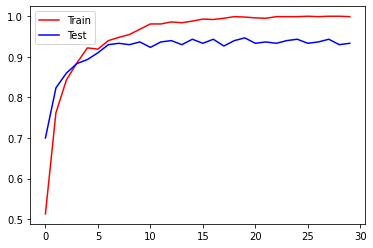

In [23]:
import matplotlib.pyplot as plt
acc = h.history["acc"]
val_acc = h.history["val_acc"]

epochs = np.arange(len(acc))

plt.plot(epochs,acc,c="red", label="Train")
plt.plot(epochs,val_acc,c="blue",label="Test")

plt.legend()

#####  베스트 모델을 찾아 저장하고, 더 이상 학습이 되지 않는다면 학습을 중단하는 코드

In [26]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
#모델을 저장할 폴더명
model_folder = "./model/"
# 해당 폴더가 없다면
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
    
#저장할 파일명 설정
#{epoch:04d} : 반복수를 4자리로 설정
#{acc:.4f} : 정확도를 소수점 4자리까지 표시

modelpath = model_folder + "CNN-{epoch:04d}-{val_acc:.4f}.hdf5"

#베스트를 찾아서 해당파일명으로 저장
# save_best_only : 더 나은 결과값만 저장
#modelcheckpoint(filepath=파일패스 , monitor=기준값,save_vest_only=True/False)

# 매 에포크 마다의 훈련 손실값 (loss)
# 매 에포크 마다의 훈련 정확도 (acc)
# 매 에포크 마다의 검증 손실값 (val_loss)
# 매 에포크 마다의 검증 정확도 (val_acc)

mc = ModelCheckpoint(filepath=modelpath,
                    monitor="val_acc",
                    save_best_only=True,
                    verbose=1)

# EarlyStopping(monitor=기준값 ,patience= 조금 더 기다리는 횟수)
# patience=20 -> 학습이 더 나아지지 않더라도 20회는 더 반복해줌

es = EarlyStopping(monitor= "val_acc",
                  patience=100)
#학습
#validation_split = 0.33 -> 검증데이터를 0.33만큼 추출해서 평가
# 0.66 학습에 사용
# callbacks -> mc와 es 두개를 조합해서 검증을함
history = model.fit(X_train,y_train,
                    epochs=50000, batch_size=50,
                   validation_split=0.33,
                   callbacks=[mc,es])

Train on 669 samples, validate on 331 samples
Epoch 1/50000
650/669 [============================>.] - ETA: 0s - loss: 1.6796e-04 - acc: 1.0000
Epoch 00001: val_acc improved from -inf to 0.98792, saving model to ./model/CNN-0001-0.9879.hdf5
669/669 [==============================] - 0s 327us/sample - loss: 1.7448e-04 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9879
Epoch 2/50000
500/669 [=====================>........] - ETA: 0s - loss: 1.2960e-04 - acc: 1.0000
Epoch 00002: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 295us/sample - loss: 1.4977e-04 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9879
Epoch 3/50000
650/669 [============================>.] - ETA: 0s - loss: 7.8517e-05 - acc: 1.0000
Epoch 00003: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 325us/sample - loss: 7.6512e-05 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9879
Epoch 4/50000
500/669 [=====================>........] - ETA: 0s - loss: 1.5

650/669 [============================>.] - ETA: 0s - loss: 0.0012 - acc: 1.0000   
Epoch 00030: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 312us/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1168 - val_acc: 0.9577
Epoch 31/50000
450/669 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 1.0000
Epoch 00031: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 325us/sample - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1006 - val_acc: 0.9607
Epoch 32/50000
650/669 [============================>.] - ETA: 0s - loss: 5.6362e-04 - acc: 1.0000
Epoch 00032: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 332us/sample - loss: 5.4908e-04 - acc: 1.0000 - val_loss: 0.1026 - val_acc: 0.9637
Epoch 33/50000
500/669 [=====================>........] - ETA: 0s - loss: 0.0022 - acc: 0.9980    
Epoch 00033: val_acc did not improve from 0.98792
669/669 [==============================] - 0s

Epoch 60/50000
500/669 [=====================>........] - ETA: 0s - loss: 1.6585e-04 - acc: 1.0000
Epoch 00060: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 288us/sample - loss: 7.0567e-04 - acc: 1.0000 - val_loss: 0.1258 - val_acc: 0.9637
Epoch 61/50000
650/669 [============================>.] - ETA: 0s - loss: 4.9047e-04 - acc: 1.0000
Epoch 00061: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 331us/sample - loss: 4.7706e-04 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9547
Epoch 62/50000
500/669 [=====================>........] - ETA: 0s - loss: 6.8548e-04 - acc: 1.0000
Epoch 00062: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 291us/sample - loss: 5.5338e-04 - acc: 1.0000 - val_loss: 0.1586 - val_acc: 0.9517
Epoch 63/50000
500/669 [=====================>........] - ETA: 0s - loss: 0.0012 - acc: 1.0000    
Epoch 00063: val_acc did not improve from 0.98792
669/669 [========

Epoch 90/50000
650/669 [============================>.] - ETA: 0s - loss: 8.1966e-05 - acc: 1.0000
Epoch 00090: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 389us/sample - loss: 8.0860e-05 - acc: 1.0000 - val_loss: 0.1444 - val_acc: 0.9577
Epoch 91/50000
550/669 [=======================>......] - ETA: 0s - loss: 5.2047e-05 - acc: 1.0000
Epoch 00091: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 385us/sample - loss: 5.8382e-05 - acc: 1.0000 - val_loss: 0.1444 - val_acc: 0.9577
Epoch 92/50000
650/669 [============================>.] - ETA: 0s - loss: 8.8701e-05 - acc: 1.0000
Epoch 00092: val_acc did not improve from 0.98792
669/669 [==============================] - 0s 353us/sample - loss: 8.6305e-05 - acc: 1.0000 - val_loss: 0.1432 - val_acc: 0.9637
Epoch 93/50000
600/669 [=========================>....] - ETA: 0s - loss: 3.9896e-05 - acc: 1.0000
Epoch 00093: val_acc did not improve from 0.98792
669/669 [========

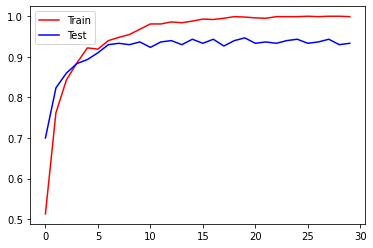

In [28]:
import matplotlib.pyplot as plt
acc = h.history["acc"]
val_acc = h.history["val_acc"]

epochs = np.arange(len(acc))

plt.plot(epochs,acc,c="red", label="Train")
plt.plot(epochs,val_acc,c="blue",label="Test")

plt.legend()

In [29]:
print("훈련 정확도 : ", model.evaluate(X_train,y_train))
print("테스트 정확도 : ", model.evaluate(X_test,y_test))

1000/1000 [==============================] - 0s 77us/sample - loss: 0.0490 - acc: 0.9880
훈련 정확도 :  [0.04897059880082452, 0.988]
300/300 [==============================] - 0s 73us/sample - loss: 0.2953 - acc: 0.9500
테스트 정확도 :  [0.2953233150020242, 0.95]
